# Convert NEXRAD files into Zarr

## Imports

In [3]:
import fsspec
import xarray as xr

from raw2zarr.builder.runner import append_files

Now let's convert some KVNX radar files hosted in the [NEXRAD](https://registry.opendata.aws/noaa-nexrad/) AWS bucket.

In [4]:
radar = "KVNX"
append_dim = "vcp_time"
engine = "nexradlevel2"
zarr_format = 3
consolidated = True if zarr_format == 2 else False
zarr_store = f"../zarr/{radar}.zarr"
query = f"2011/05/20/{radar}/{radar}"
str_bucket = "s3://noaa-nexrad-level2/"

In [5]:
fs = fsspec.filesystem("s3", anon=True)
radar_files = [f"s3://{i}" for i in sorted(fs.glob(f"{str_bucket}{query}*"))]

We are interested in some measruements on May 20, 2011. Thus those files are from file 137 to 165. In total 28 VCP files will be donwloaded and converted into hierarchical structure using `xarray.DataTree` and stored using `Zarr` format.

In [6]:
len(radar_files[135:170])

35

lets convert those files into Zarr format using raw2zarr python package. We can use `append_parallel` to use multiprocessing to speed up our process

In [5]:
?append_files

Signature:
append_files(
    radar_files: 'Iterable[str | os.PathLike]',
    append_dim: 'str',
    zarr_store: 'str',
    process_mode: "Literal['sequential', 'parallel']" = 'sequential',
    engine: 'str' = 'iris',
    **kwargs,
) -> 'None'
Docstring:
Append radar files to a Zarr store using either sequential or parallel processing.

This function serves as a unified interface for appending radar data into a Zarr store.
It supports both serial and Dask-parallel strategies, controlled via the `mode` argument.
Internally, it delegates to `append_sequential` or `append_parallel`.

Parameters:
    radar_files (Iterable[str | os.PathLike]):
        A list or generator of radar file paths to be appended.
    append_dim (str):
        The dimension name to append data along (e.g., "vcp_time").
    zarr_store (str):
        Path to the destination Zarr store on disk or cloud.
    process_mode (Literal["sequential", "parallel"], optional):
        Whether to use sequential or parallel process

In [6]:
%%time
append_files(
    radar_files[137:165],
    zarr_store=zarr_store,
    append_dim=append_dim,
    zarr_format=zarr_format,
    batch_size=10,
    engine=engine,
    consolidated=consolidated,
    process_mode="parallel",
)

CPU times: user 2min 16s, sys: 49.6 s, total: 3min 6s
Wall time: 3min 48s


## Read the radar datatree stored in Zarr format

In [7]:
!ls ../zarr/KVNX.zarr/

VCP-12	zarr.json


In [8]:
zarr_store

'../zarr/KVNX.zarr'

In [9]:
%%time
dt_radar = xr.open_datatree(
    zarr_store, 
    engine="zarr", 
    consolidated=False, 
    zarr_format=3, 
    chunks={}
)

CPU times: user 2.63 s, sys: 543 ms, total: 3.17 s
Wall time: 3.08 s


In [10]:
display(dt_radar)

<xarray.DataTree>
Group: /
└── Group: /VCP-12
    │   Dimensions:              (vcp_time: 28)
    │   Coordinates:
    │     * vcp_time             (vcp_time) datetime64[ns] 224B 2011-05-20T09:57:27 ....
    │   Data variables:
    │       altitude             (vcp_time) float64 224B dask.array<chunksize=(1,), meta=np.ndarray>
    │       instrument_type      (vcp_time) object 224B dask.array<chunksize=(28,), meta=np.ndarray>
    │       latitude             (vcp_time) float64 224B dask.array<chunksize=(1,), meta=np.ndarray>
    │       platform_type        (vcp_time) object 224B dask.array<chunksize=(28,), meta=np.ndarray>
    │       longitude            (vcp_time) float64 224B dask.array<chunksize=(1,), meta=np.ndarray>
    │       time_coverage_start  (vcp_time) object 224B dask.array<chunksize=(28,), meta=np.ndarray>
    │       time_coverage_end    (vcp_time) object 224B dask.array<chunksize=(28,), meta=np.ndarray>
    │       volume_number        (vcp_time) float64 224B dask.array<chunksize=(1,), meta=np.ndarray>
    │   Attributes:
    │       Conventions:      None
    │       instrument_name:  KVNX
    │       version:          None
    │       title:            None
    │       institution:      None
    │       references:       None
    │       source:           None
    │       history:          None
    │       comment:          im/exported using xradar
    │       scan_name:        VCP-12
    ├── Group: /VCP-12/georeferencing_correction
    │       Dimensions:    ()
    │       Coordinates:
    │           altitude   int64 8B ...
    │           latitude   float64 8B ...
    │           longitude  float64 8B ...
    ├── Group: /VCP-12/sweep_10
    │       Dimensions:            (vcp_time: 28, azimuth: 360, range: 924)
    │       Coordinates:
    │           altitude           int64 8B ...
    │         * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
    │           crs_wkt            int64 8B ...
    │           elevation          (azimuth) float64 3kB dask.array<chunksize=(360,), meta=np.ndarray>
    │           latitude           float64 8B ...
    │           longitude          float64 8B ...
    │         * range              (range) float32 4kB 2.125e+03 2.375e+03 ... 2.329e+05
    │           time               (azimuth) datetime64[ns] 3kB dask.array<chunksize=(360,), meta=np.ndarray>
    │           x                  (azimuth, range) float64 3MB dask.array<chunksize=(90, 462), meta=np.ndarray>
    │           y                  (azimuth, range) float64 3MB dask.array<chunksize=(90, 462), meta=np.ndarray>
    │           z                  (azimuth, range) float64 3MB dask.array<chunksize=(90, 462), meta=np.ndarray>
    │       Data variables:
    │           DBZH               (vcp_time, azimuth, range) float64 75MB dask.array<chunksize=(1, 90, 462), meta=np.ndarray>
    │           PHIDP              (vcp_time, azimuth, range) float64 75MB dask.array<chunksize=(1, 90, 462), meta=np.ndarray>
    │           prt_mode           (vcp_time) object 224B dask.array<chunksize=(28,), meta=np.ndarray>
    │           follow_mode        (vcp_time) object 224B dask.array<chunksize=(28,), meta=np.ndarray>
    │           RHOHV              (vcp_time, azimuth, range) float64 75MB dask.array<chunksize=(1, 90, 462), meta=np.ndarray>
    │           sweep_fixed_angle  (vcp_time) float64 224B dask.array<chunksize=(1,), meta=np.ndarray>
    │           sweep_number       (vcp_time) float64 224B dask.array<chunksize=(1,), meta=np.ndarray>
    │           sweep_mode         (vcp_time) object 224B dask.array<chunksize=(28,), meta=np.ndarray>
    │           WRADH              (vcp_time, azimuth, range) float64 75MB dask.array<chunksize=(1, 90, 462), meta=np.ndarray>
    │           ZDR                (vcp_time, azimuth, range) float64 75MB dask.array<chunksize=(1, 90, 462), meta=np.ndarray>
    │           VRADH              (vcp_time, azimuth, range) float64 75MB dask.array<chunksize=(1, 90, 4

In [11]:
list(dt_radar.children)

['VCP-12']

In [12]:
list(dt_radar["VCP-12"].children)

['georeferencing_correction',
 'sweep_10',
 'sweep_0',
 'radar_parameters',
 'sweep_1',
 'sweep_11',
 'sweep_12',
 'sweep_15',
 'sweep_14',
 'sweep_13',
 'sweep_16',
 'sweep_4',
 'sweep_2',
 'sweep_3',
 'sweep_6',
 'sweep_5',
 'sweep_7',
 'sweep_9',
 'sweep_8']

We can now access each sweep by using a key-value method. Let's check the lowest elevation angle

In [13]:
ds_lowest = dt_radar["VCP-12/sweep_0"].ds
display(ds_lowest)

<xarray.DatasetView> Size: 1GB
Dimensions:            (vcp_time: 28, azimuth: 720, range: 1832)
Coordinates:
  * vcp_time           (vcp_time) datetime64[ns] 224B 2011-05-20T09:57:27 ......
    altitude           int64 8B ...
  * azimuth            (azimuth) float64 6kB 0.25 0.75 1.25 ... 359.2 359.8
    crs_wkt            int64 8B ...
    latitude           float64 8B ...
    elevation          (azimuth) float64 6kB dask.array<chunksize=(720,), meta=np.ndarray>
    longitude          float64 8B ...
  * range              (range) float32 7kB 2.125e+03 2.375e+03 ... 4.599e+05
    time               (azimuth) datetime64[ns] 6kB dask.array<chunksize=(720,), meta=np.ndarray>
    z                  (azimuth, range) float64 11MB dask.array<chunksize=(180, 458), meta=np.ndarray>
    y                  (azimuth, range) float64 11MB dask.array<chunksize=(180, 458), meta=np.ndarray>
    x                  (azimuth, range) float64 11MB dask.array<chunksize=(180, 458), meta=np.ndarray>
Data variables:
    DBZH               (vcp_time, azimuth, range) float64 295MB dask.array<chunksize=(1, 180, 458), meta=np.ndarray>
    prt_mode           (vcp_time) object 224B dask.array<chunksize=(28,), meta=np.ndarray>
    PHIDP              (vcp_time, azimuth, range) float64 295MB dask.array<chunksize=(1, 180, 458), meta=np.ndarray>
    RHOHV              (vcp_time, azimuth, range) float64 295MB dask.array<chunksize=(1, 180, 458), meta=np.ndarray>
    follow_mode        (vcp_time) object 224B dask.array<chunksize=(28,), meta=np.ndarray>
    sweep_fixed_angle  (vcp_time) float64 224B dask.array<chunksize=(1,), meta=np.ndarray>
    sweep_number       (vcp_time) float64 224B dask.array<chunksize=(1,), meta=np.ndarray>
    sweep_mode         (vcp_time) object 224B dask.array<chunksize=(28,), meta=np.ndarray>
    ZDR                (vcp_time, azimuth, range) float64 295MB dask.array<chunksize=(1, 180, 458), meta=np.ndarray>

Before creating a radar plot we need to georeference the dataset. This can be done using `xradar.georeference` module

Now we can create a radial plot

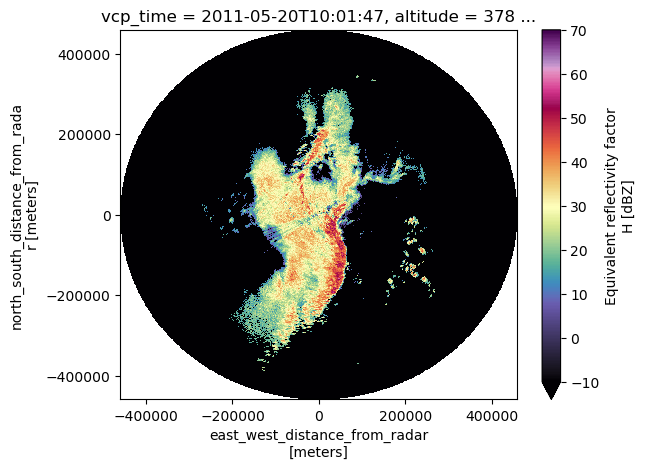

In [14]:
ds_lowest.isel(vcp_time=1).DBZH.plot(
    x="x", y="y", cmap="ChaseSpectral", vmin=-10, vmax=70
)

Our radar datatree now have the `vcp_time` coordinate that allows ud to do slicing along the full tree.

Initially, our `DataTree` has 28 timestamps as shown here,

In [15]:
dt_radar["VCP-12"].vcp_time

<xarray.DataArray 'vcp_time' (vcp_time: 28)> Size: 224B
array(['2011-05-20T09:57:27.000000000', '2011-05-20T10:01:47.000000000',
       '2011-05-20T10:06:08.000000000', '2011-05-20T10:10:28.000000000',
       '2011-05-20T10:14:47.000000000', '2011-05-20T10:19:06.000000000',
       '2011-05-20T10:23:27.000000000', '2011-05-20T10:27:47.000000000',
       '2011-05-20T10:32:07.000000000', '2011-05-20T10:36:28.000000000',
       '2011-05-20T10:40:47.000000000', '2011-05-20T10:45:07.000000000',
       '2011-05-20T10:49:28.000000000', '2011-05-20T10:53:49.000000000',
       '2011-05-20T10:58:09.000000000', '2011-05-20T11:02:30.000000000',
       '2011-05-20T11:06:51.000000000', '2011-05-20T11:11:11.000000000',
       '2011-05-20T11:15:30.000000000', '2011-05-20T11:19:51.000000000',
       '2011-05-20T11:24:10.000000000', '2011-05-20T11:28:30.000000000',
       '2011-05-20T11:32:51.000000000', '2011-05-20T11:37:10.000000000',
       '2011-05-20T11:41:30.000000000', '2011-05-20T11:45:50.000000000',
       '2011-05-20T11:50:11.000000000', '2011-05-20T11:54:31.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * vcp_time  (vcp_time) datetime64[ns] 224B 2011-05-20T09:57:27 ... 2011-05-...
Attributes:
    description:  Volume Coverage Pattern time since start of volume scan

However, we can select data from `'2011-05-20 10:00'` to `'2011-05-20 11:00'`

In [16]:
display(
    dt_radar.sel(vcp_time=slice("2011-05-20 10:00", "2011-05-20 11:00"))[
        "VCP-12/sweep_0"
    ]
)

<xarray.DataTree 'sweep_0'>
Group: /VCP-12/sweep_0
    Dimensions:            (vcp_time: 14, azimuth: 720, range: 1832)
    Coordinates:
        altitude           int64 8B ...
      * azimuth            (azimuth) float64 6kB 0.25 0.75 1.25 ... 359.2 359.8
        crs_wkt            int64 8B ...
        latitude           float64 8B ...
        elevation          (azimuth) float64 6kB dask.array<chunksize=(720,), meta=np.ndarray>
        longitude          float64 8B ...
      * range              (range) float32 7kB 2.125e+03 2.375e+03 ... 4.599e+05
        time               (azimuth) datetime64[ns] 6kB dask.array<chunksize=(720,), meta=np.ndarray>
        z                  (azimuth, range) float64 11MB dask.array<chunksize=(180, 458), meta=np.ndarray>
        y                  (azimuth, range) float64 11MB dask.array<chunksize=(180, 458), meta=np.ndarray>
        x                  (azimuth, range) float64 11MB dask.array<chunksize=(180, 458), meta=np.ndarray>
    Inherited coordinates:
      * vcp_time           (vcp_time) datetime64[ns] 112B 2011-05-20T10:01:47 ......
    Data variables:
        DBZH               (vcp_time, azimuth, range) float64 148MB dask.array<chunksize=(1, 180, 458), meta=np.ndarray>
        prt_mode           (vcp_time) object 112B dask.array<chunksize=(14,), meta=np.ndarray>
        PHIDP              (vcp_time, azimuth, range) float64 148MB dask.array<chunksize=(1, 180, 458), meta=np.ndarray>
        RHOHV              (vcp_time, azimuth, range) float64 148MB dask.array<chunksize=(1, 180, 458), meta=np.ndarray>
        follow_mode        (vcp_time) object 112B dask.array<chunksize=(14,), meta=np.ndarray>
        sweep_fixed_angle  (vcp_time) float64 112B dask.array<chunksize=(1,), meta=np.ndarray>
        sweep_number       (vcp_time) float64 112B dask.array<chunksize=(1,), meta=np.ndarray>
        sweep_mode         (vcp_time) object 112B dask.array<chunksize=(14,), meta=np.ndarray>
        ZDR                (vcp_time, azimuth, range) float64 148MB dask.array<chunksize=(1, 180, 458), meta=np.ndarray>